In [1]:
from qcg.generators import gen_supremacy
from helper_fun import evaluate_circ, get_evaluator_info, get_circ_saturated_shots, readout_mitigation, reverseBits, apply_measurement, cross_entropy
from qiskit.compiler import transpile, assemble
from qiskit import Aer, execute
import numpy as np
import matplotlib.pyplot as plt

circ = gen_supremacy(2,4,8)
total_shots = 8192*15
sv_noiseless_fc = evaluate_circ(circ=circ,backend='statevector_simulator',evaluator_info=None)
qasm_noiseless_fc = evaluate_circ(circ=circ,backend='noiseless_qasm_simulator',evaluator_info={'num_shots':total_shots})


device_name = 'ibmq_boeblingen'
evaluator_info = get_evaluator_info(circ=circ,device_name=device_name,fields=['device','basis_gates','coupling_map','properties','initial_layout'])
evaluator_info['num_shots'] = total_shots
qc=apply_measurement(circ)
mapped_circuit = transpile(qc,
        backend=evaluator_info['device'], basis_gates=evaluator_info['basis_gates'],
        coupling_map=evaluator_info['coupling_map'],backend_properties=evaluator_info['properties'],
        initial_layout=evaluator_info['initial_layout'])
job = execute(mapped_circuit, backend=Aer.get_backend('qasm_simulator'), shots=total_shots)
result = job.result()
counts = result.get_counts(0)

Generating 2x4, 1+8+1 supremacy circuit


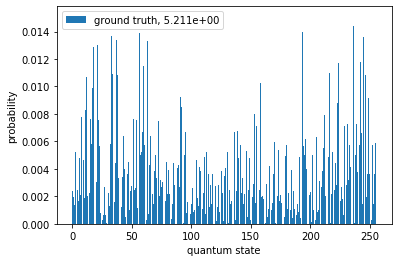

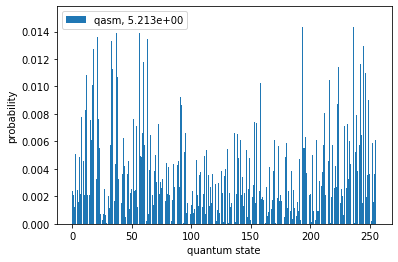

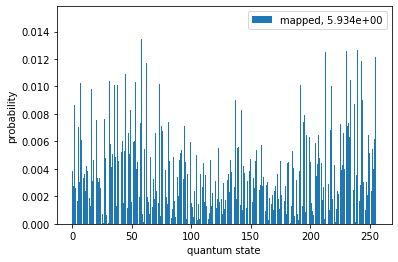

In [3]:
mapped_prob = [0 for x in range(np.power(2,len(circ.qubits)))]
for state in counts:
    reversed_state = reverseBits(int(state,2),len(circ.qubits))
#     reversed_state = int(state,2)
    mapped_prob[reversed_state] = counts[state]/total_shots


d1 = sv_noiseless_fc
d2 = qasm_noiseless_fc
d3 = mapped_prob

plot_range = min(1024,len(d1))
x = np.arange(len(d1))[:plot_range]
y_lim = 0
for d in [d1,d2,d3]:
    y_lim = max(y_lim,max(d))
y_lim *= 1.1

plt.figure()
plt.bar(x,height=d1[:plot_range],label='ground truth, %.3e'%cross_entropy(d1,d1))
plt.ylim(0,y_lim)
plt.xlabel('quantum state')
plt.ylabel('probability')
plt.legend()
plt.show()

plt.figure()
plt.bar(x,height=d2[:plot_range],label='qasm, %.3e'%cross_entropy(d1,d2))
plt.ylim(0,y_lim)
plt.xlabel('quantum state')
plt.ylabel('probability')
plt.legend()
plt.show()

plt.figure()
plt.bar(x,height=d3[:plot_range],label='mapped, %.3e'%cross_entropy(d1,d3))
plt.ylim(0,y_lim)
plt.xlabel('quantum state')
plt.ylabel('probability')
plt.legend()
plt.show()